In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import scipy.spatial.distance
import scipy
import pandas as pd

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

# MNIST Daten vorbereiten

In [0]:
def data_preparation():
  #Trainings- und Testdaten
  global digits_train, labels_train
  mnist_train = tf.keras.datasets.mnist.load_data()[0]
  digits_train, labels_train = mnist_train[0], mnist_train[1]

  global digits_test, labels_test
  mnist_test = tf.keras.datasets.mnist.load_data()[1]
  digits_test, labels_test = mnist_test[0], mnist_test[1]
  
  #Anzahl der Samples in train und test
  global n_train
  n_train = digits_train.shape[0]
  n_test = digits_test.shape[0]

  #Anzahl der Pixel
  m = digits_train.shape[1]**2

  #Vektor aus Matrizen erstellen -> digits flat
  global digits_train_flat, digits_test_flat
  digits_train_flat = digits_train.reshape([n_train, m])
  digits_test_flat = digits_test.reshape([n_test, m])

  #Subsamples der unserer Datensätze
  idx = np.random.randint(n_train, size = 10000)
  global digits_train_sample, labels_train_sample
  digits_train_sample = digits_train_flat[idx]
  labels_train_sample = labels_train[idx]

  global digits_test_sample, labels_test_sample, digits_test_sample_n_flat
  idx = np.random.randint(n_test, size = 100)
  digits_test_sample_n_flat = digits_test[idx]
  digits_test_sample = digits_test_flat[idx]
  labels_test_sample = labels_test[idx]

# **Confusion Matrix vorbereiten**

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# KNN

In [0]:
def knn(k):
  #Entfernugen berechnen. Man erhält als Matrix alle Entfernungen und kann dann die k nächsten Nachbarn ermitteln
  #k = Nachbarn
  print("KNN für k=", k)
  #Distanzen 
  dists = scipy.spatial.distance.cdist(digits_train_sample, digits_test_sample, metric='euclid')
  #index der nächsten Nachbarn
  idx_nearest = np.argpartition(dists, k, axis=0)[:k]
  nearest_dists = np.take(digits_train_sample, idx_nearest)

  knn_neighbors = labels_train_sample[idx_nearest]
  #remove count array with [0]
  knn_result = scipy.stats.mode(knn_neighbors)[0]
  knn_result = knn_result[0]
  return knn_result

In [0]:
def calc_error(knn_result):
  n_error = 0
  check_matrix = labels_test_sample == knn_result
  for check_bool in check_matrix:
    if check_bool == False:
      n_error = n_error + 1
  error_rate = n_error / len(knn_result) * 100
  print("Errorrate: ", error_rate, "%")

  error = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
  total ={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
  global error_array
  error_array = []
  for i in range(len(labels_test_sample)):
    if labels_test_sample[i] != knn_result[i]:
      error[labels_test_sample[i]] +=1
      total[labels_test_sample[i]] +=1
      error_array.append(i)
    else:
      total[labels_test_sample[i]] +=1
  
  errorrate = {}
  for i in range(0,10):
    errorrate[i] = (error[i] / total[i]) * 100
    print("Errorrate für", i, " = ", round(errorrate[i], 2), "%")
  #print(pd.DataFrame([error]))
  #print(pd.DataFrame([total]))
  print("Index der Fehler im Sampleset: ",error_array)
  
  print("")
  #Alle Bilder anzeigen die falsch zugeordnet wurden
  for i in range(len(error_array)):
    print("Bild Nr.", i+1)
    print("Richtiges Label", labels_test_sample[error_array[i]])
    print("Knn Label Ergebnis:", knn_result[error_array[i]])
    plt.imshow(digits_test_sample_n_flat[error_array[i]])
    plt.show()
  plot_confusion_matrix(labels_test_sample, knn_result, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

KNN für k= 2
Errorrate:  6.0 %
Errorrate für 0  =  0.0 %
Errorrate für 1  =  0.0 %
Errorrate für 2  =  20.0 %
Errorrate für 3  =  0.0 %
Errorrate für 4  =  12.5 %
Errorrate für 5  =  8.33 %
Errorrate für 6  =  0.0 %
Errorrate für 7  =  11.11 %
Errorrate für 8  =  0.0 %
Errorrate für 9  =  0.0 %
Index der Fehler im Sampleset:  [3, 28, 43, 61, 87, 91]

Bild Nr. 1
Richtiges Label 2
Knn Label Ergebnis: 7


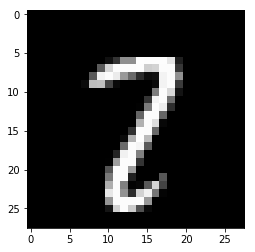

Bild Nr. 2
Richtiges Label 4
Knn Label Ergebnis: 9


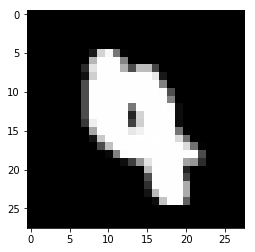

Bild Nr. 3
Richtiges Label 5
Knn Label Ergebnis: 3


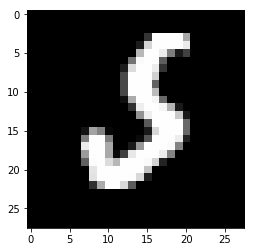

Bild Nr. 4
Richtiges Label 2
Knn Label Ergebnis: 0


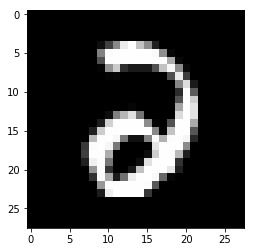

Bild Nr. 5
Richtiges Label 2
Knn Label Ergebnis: 7


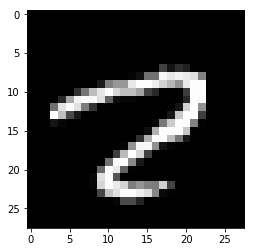

Bild Nr. 6
Richtiges Label 7
Knn Label Ergebnis: 1


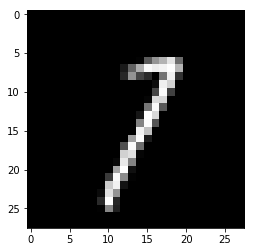

Confusion matrix, without normalization
[[ 7  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0 12  0  0  0  0  2  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  1]
 [ 0  0  0  1  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0]
 [ 0  1  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  0  0 13]]


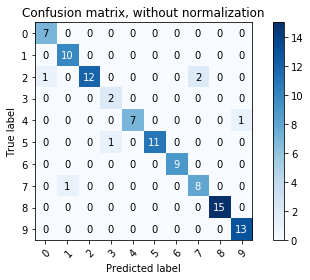

In [0]:
data_preparation()
knn_result = knn(2)
calc_error(knn_result)

KNN für k= 4
Errorrate:  4.0 %
Errorrate für 0  =  0.0 %
Errorrate für 1  =  10.0 %
Errorrate für 2  =  8.33 %
Errorrate für 3  =  0.0 %
Errorrate für 4  =  0.0 %
Errorrate für 5  =  0.0 %
Errorrate für 6  =  0.0 %
Errorrate für 7  =  9.09 %
Errorrate für 8  =  0.0 %
Errorrate für 9  =  14.29 %
Index der Fehler im Sampleset:  [10, 12, 19, 33]

Bild Nr. 1
Richtiges Label 2
Knn Label Ergebnis: 7


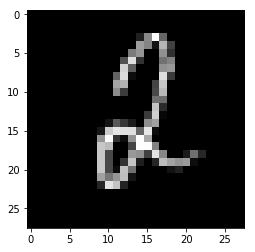

Bild Nr. 2
Richtiges Label 9
Knn Label Ergebnis: 0


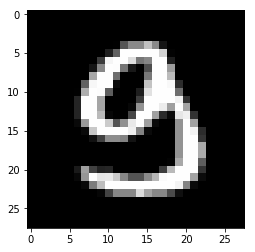

Bild Nr. 3
Richtiges Label 1
Knn Label Ergebnis: 6


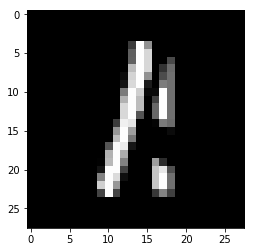

Bild Nr. 4
Richtiges Label 7
Knn Label Ergebnis: 1


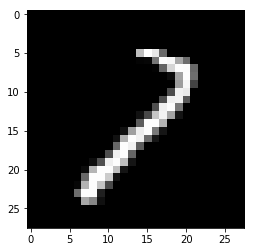

Confusion matrix, without normalization
[[ 7  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  1  0  0  0]
 [ 0  0 11  0  0  0  0  1  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0]
 [ 0  1  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 1  0  0  0  0  0  0  0  0  6]]


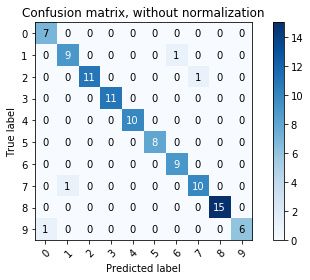

In [0]:
data_preparation()
knn_result = knn(4)
calc_error(knn_result)

KNN für k= 8
Errorrate:  4.0 %
Errorrate für 0  =  0.0 %
Errorrate für 1  =  0.0 %
Errorrate für 2  =  10.0 %
Errorrate für 3  =  0.0 %
Errorrate für 4  =  0.0 %
Errorrate für 5  =  9.09 %
Errorrate für 6  =  0.0 %
Errorrate für 7  =  14.29 %
Errorrate für 8  =  0.0 %
Errorrate für 9  =  0.0 %
Index der Fehler im Sampleset:  [19, 79, 90, 98]

Bild Nr. 1
Richtiges Label 2
Knn Label Ergebnis: 3


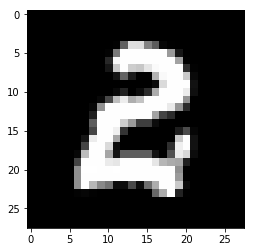

Bild Nr. 2
Richtiges Label 5
Knn Label Ergebnis: 9


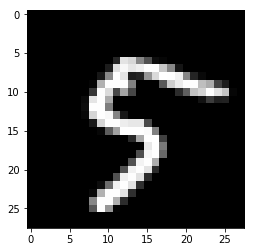

Bild Nr. 3
Richtiges Label 7
Knn Label Ergebnis: 2


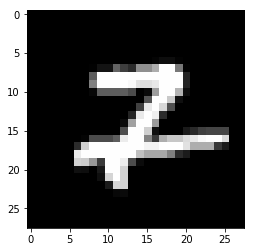

Bild Nr. 4
Richtiges Label 7
Knn Label Ergebnis: 1


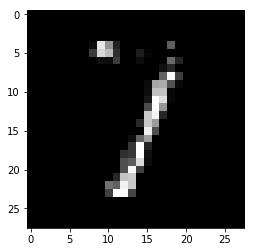

Confusion matrix, without normalization
[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  9  1  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  1]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  1  1  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 12]]


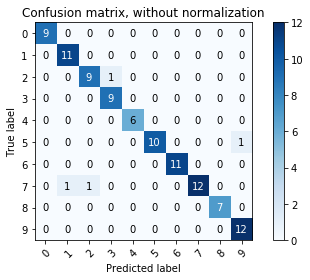

In [0]:
data_preparation()
knn_result = knn(8)
calc_error(knn_result)

# **Antwort Teil 1**
**KNN für k= 2**
Errorrate:  6.0 %

Errorrate für 2  =  20.0 %,
Errorrate für 4  =  12.5 %,
Errorrate für 5  =  8.33 %,
Errorrate für 7  =  11.11 %

**KNN für k= 4**
Errorrate:  4.0 %

Errorrate für 1  =  10.0 %,
Errorrate für 2  =  8.33 %,
Errorrate für 7  =  9.09 %,
Errorrate für 9  =  14.29 %

**KNN für k= 8**
Errorrate:  4.0 %

Errorrate für 2  =  10.0 %,
Errorrate für 5  =  9.09 %,
Errorrate für 7  =  14.29 %

-------
Wenn man sich die Zahlen ansieht fällt auf, dass die Zahlen 2, 5 und 7 besonders häufig verwechselt werden. 2 und 7 sind sogar in k=2, k=4 und k=8 vertreten obwohl es sich jedes mal um ein neues Sampleset handelt. Wenn man sich dann ansieht mit welchen Zahlen unser Algorithmus sich vertan hat, fällt auf dass Kombinationen aus 7 und 2 (4mal), sowie Kombinationen aus 7 und 1 (3mal) besonders häufig auftreten. Ansonsten liegen keine Kombinationen vor, die häufiger als einmal vorkommen.

Nach betrachten der Fehlerbilder (siehe oben) Fällt auf dass KNN immer dann Schwierigkeiten hat, wenn es sich um Zahlen handelt, die sich ähnlich sind oder teils gleiche Formen haben wie eine andere Zahl. Beispeilsweise wenn bei der 7 der Strich in der Mitte nicht deutlich ist. Ebenfalls lässt sich aus den Daten schließen, dass KNN mit dem rauschen und variieren der Schriftbreite in manchen Bildern Probleme hat, wodurch die einzelnen Fehler entstehen.

# KMEANS

In [0]:
def kmeans(n_iterations):
  print("KNN für", n_iterations, "Iterationen")
  #1000 Sampledaten aus den 60000 Trainingsdaten
  n_sample = 1000
  idx = np.random.randint(n_train, size=n_sample)
  global x_sample, y_sample
  x_sample = digits_train_flat[idx]
  y_sample = labels_train[idx]
  #Anzahl Cluster
  global k
  k = 10

  # init centroids
  # 10 random Centroids finden
  idx_centroid = np.random.randint(n_sample, size=k)
  #Centroids in eigene Variable speichern
  centroids = x_sample[idx_centroid]

  idx_centroid

  # init centroids
  #range für iterations anpassen
  global labels
  for j in range(n_iterations):
      
      # calc distances
      dists = scipy.spatial.distance.cdist(x_sample, centroids, metric='euclid')
      
      # label according to nearest centroids
      
      labels = np.argmin(dists, axis=1)
      
      # get new centroids
      centroid_list = [x_sample[labels == i].mean(0) for i in range(k)]
      centroids = np.stack(centroid_list)

In [0]:
def cluster_output():
  gesamt = 0
  for i in range(k):
    size = y_sample[labels == i].shape[0]
    count_numbers = np.bincount(y_sample[labels == i])
    number_idx = count_numbers.argmax()
    correct = count_numbers[number_idx]
    percentage = (correct / size) * 100
    gesamt += size
    print("Clustergröße: ", size)
    print("Verteilung der Zahlen", count_numbers)
    print("Index der meisten Zahlen", number_idx)
    print("Richtig zugeordnet", correct)
    print("Cluster " + str(i) + " besteht zu " + str(round(percentage, 2)) + " % aus der Zahl" + str(number_idx))
    #print(gesamt)
    print("___________________________________________")


In [0]:
data_preparation()
kmeans(1000)
cluster_output()

KNN für 1000 Iterationen
Clustergröße:  140
Verteilung der Zahlen [ 0  0  1  1 38  5  0 43  1 51]
Index der meisten Zahlen 9
Richtig zugeordnet 51
Cluster 0 besteht zu 36.43 % aus der Zahl9
___________________________________________
Clustergröße:  69
Verteilung der Zahlen [ 7  0  0 24  0 30  1  0  6  1]
Index der meisten Zahlen 5
Richtig zugeordnet 30
Cluster 1 besteht zu 43.48 % aus der Zahl5
___________________________________________
Clustergröße:  82
Verteilung der Zahlen [19  0  0  2  1 20 37  0  3]
Index der meisten Zahlen 6
Richtig zugeordnet 37
Cluster 2 besteht zu 45.12 % aus der Zahl6
___________________________________________
Clustergröße:  102
Verteilung der Zahlen [ 1  0  4  0 30  1 57  3  1  5]
Index der meisten Zahlen 6
Richtig zugeordnet 57
Cluster 3 besteht zu 55.88 % aus der Zahl6
___________________________________________
Clustergröße:  67
Verteilung der Zahlen [ 0  0 59  5  0  0  0  1  2]
Index der meisten Zahlen 2
Richtig zugeordnet 59
Cluster 4 besteht zu 88.06

# **Antwort Teil 2**

**KNN für 1000 Iterationen**

Clustergröße:  140

Verteilung der Zahlen [ 0  0  1  1 38  5  0 43  1 51]

Index der meisten Zahlen 9

Richtig zugeordnet 51

Cluster 0 besteht zu 36.43 % aus der Zahl9
___________________________________________
Clustergröße:  69

Verteilung der Zahlen [ 7  0  0 24  0 30  1  0  6  1]

Index der meisten Zahlen 5

Richtig zugeordnet 30

Cluster 1 besteht zu 43.48 % aus der Zahl5
___________________________________________
Clustergröße:  82

Verteilung der Zahlen [19  0  0  2  1 20 37  0  3]

Index der meisten Zahlen 6

Richtig zugeordnet 37

Cluster 2 besteht zu 45.12 % aus der Zahl6
___________________________________________
Clustergröße:  102

Verteilung der Zahlen [ 1  0  4  0 30  1 57  3  1  5]

Index der meisten Zahlen 6

Richtig zugeordnet 57

Cluster 3 besteht zu 55.88 % aus der Zahl6
___________________________________________
Clustergröße:  67

Verteilung der Zahlen [ 0  0 59  5  0  0  0  1  2]

Index der meisten Zahlen 2

Richtig zugeordnet 59

Cluster 4 besteht zu 88.06 % aus der Zahl2
___________________________________________
Clustergröße:  90

Verteilung der Zahlen [ 0 48  9  0  4  9  0  6 11  3]

Index der meisten Zahlen 1

Richtig zugeordnet 48

Cluster 5 besteht zu 53.33 % aus der Zahl1
___________________________________________
Clustergröße:  101

Verteilung der Zahlen [ 1 78  5  2  1  3  2  4  2  3]

Index der meisten Zahlen 1

Richtig zugeordnet 78

Cluster 6 besteht zu 77.23 % aus der Zahl1
___________________________________________
Clustergröße:  144

Verteilung der Zahlen [ 0  0  0  2 25  8  0 61  7 41]

Index der meisten Zahlen 7

Richtig zugeordnet 61

Cluster 7 besteht zu 42.36 % aus der Zahl7
___________________________________________
Clustergröße:  64

Verteilung der Zahlen [62  0  0  1  0  0  1]

Index der meisten Zahlen 0

Richtig zugeordnet 62

Cluster 8 besteht zu 96.88 % aus der Zahl0
___________________________________________
Clustergröße:  141

Verteilung der Zahlen [ 7  0  5 46  0 28  1  0 50  4]

Index der meisten Zahlen 8

Richtig zugeordnet 50

Cluster 9 besteht zu 35.46 % aus der Zahl8

------
Beim Betrachten der Daten fällt auf, dass in den Clustern die Kombinationen 5 und 9, 5 und 3, 6 und 0, 8 und 3 vorkommen, wenn ein Cluster nicht eindeutig ist. Auch hier zeigt sich, dass der Algorithmus seine Probleme hat, sobald sich die Zahlen anfagen zu ähneln.

# MNIST Datensatz visualisiert (10000 samples)

11493376/11490434 [==============================] - 0s 0us/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.439s...
[t-SNE] Computed neighbors for 10000 samples in 181.872s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 432.369362
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.022591
[t-SNE] K

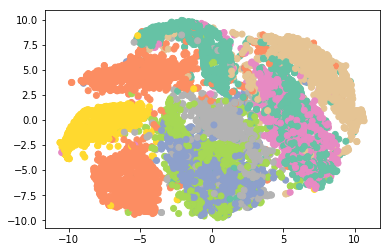

In [0]:
data_preparation()
_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
embedding = _tsne.fit_transform(digits_train_sample)

color_map = sns.color_palette("Set2", 10)
colors = [color_map[l-1] for l in labels_train_sample]
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)

3 ---
1


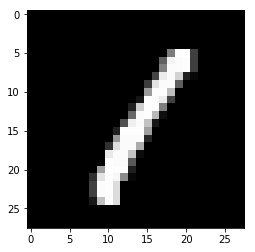

6 ---
1


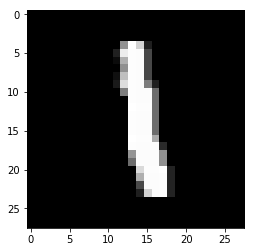

8 ---
1


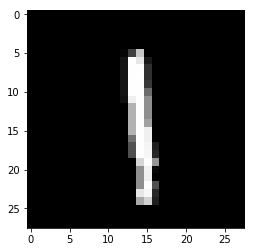

14 ---
1


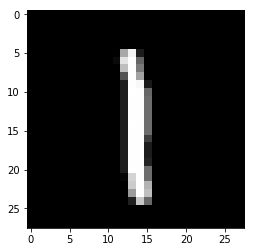

23 ---
1


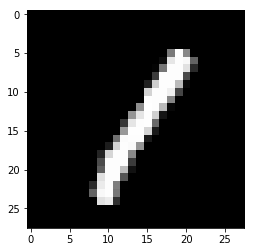

24 ---
1


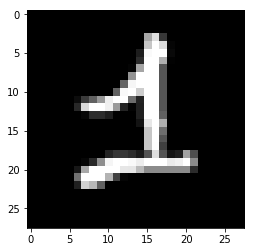

40 ---
1


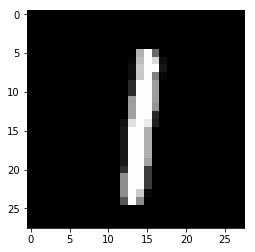

59 ---
1


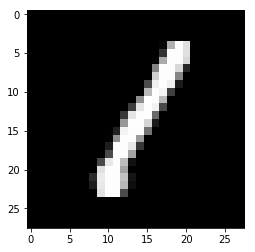

67 ---
1


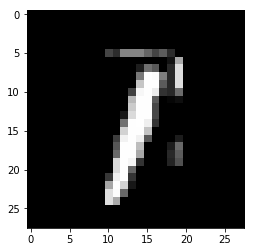

70 ---
1


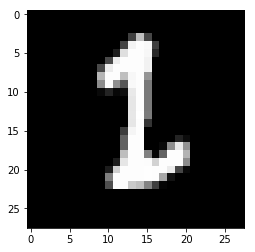

72 ---
1


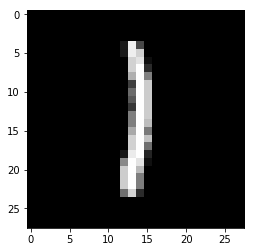

77 ---
1


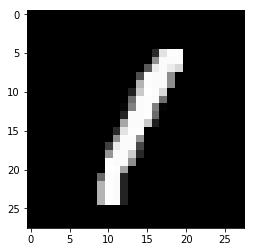

78 ---
1


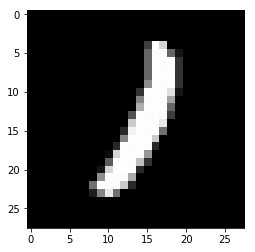

99 ---
1


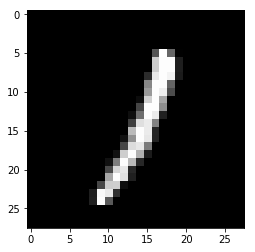

102 ---
1


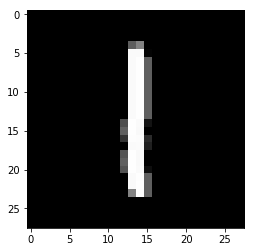

104 ---
1


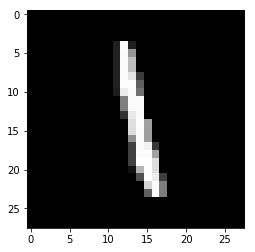

105 ---
1


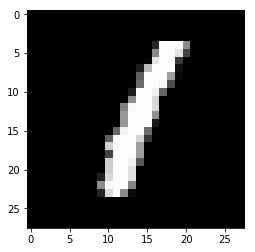

112 ---
1


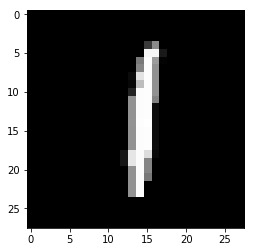

113 ---
1


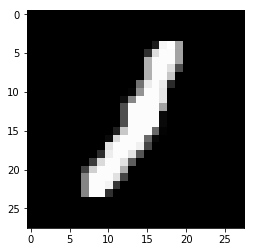

124 ---
1


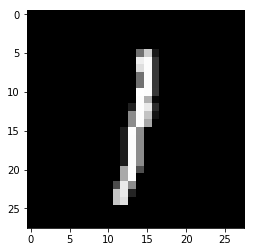

128 ---
1


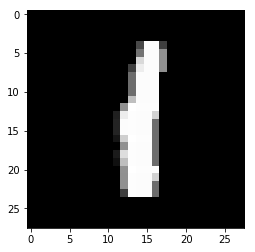

134 ---
1


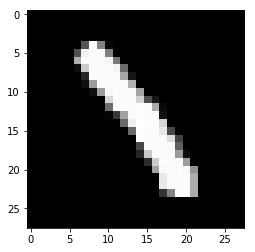

152 ---
1


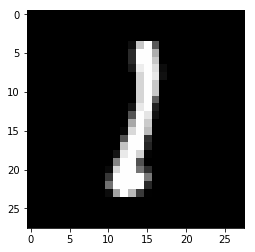

174 ---
1


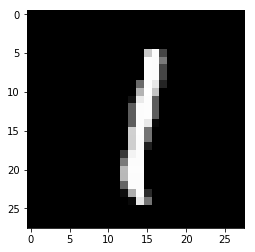

177 ---
1


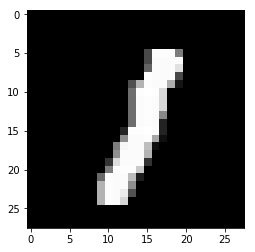

184 ---
1


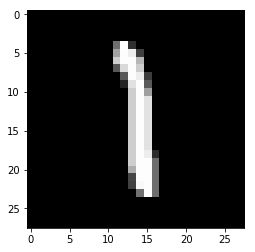

200 ---
1


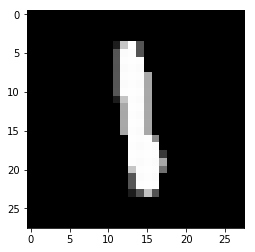

201 ---
1


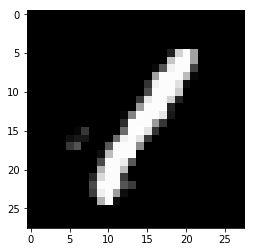

205 ---
1


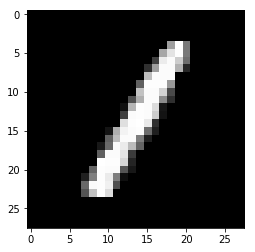

208 ---
1


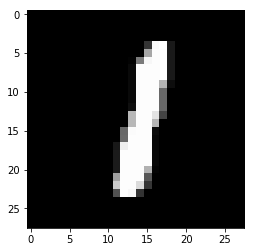

211 ---
1


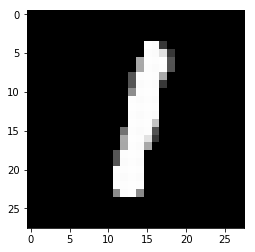

224 ---
1


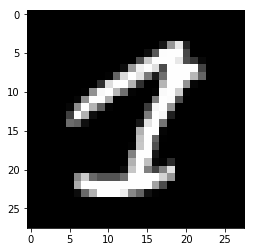

231 ---
1


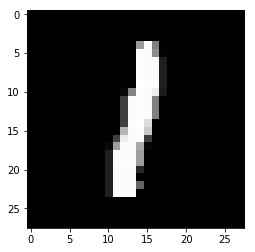

248 ---
1


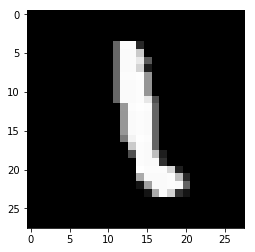

251 ---
1


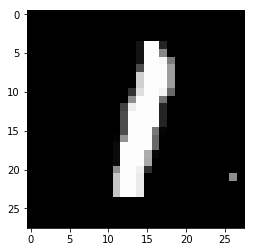

269 ---
1


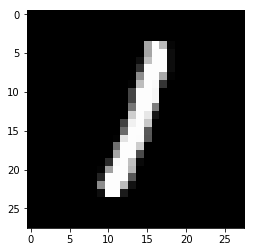

270 ---
1


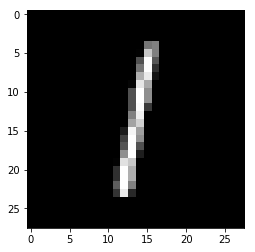

276 ---
1


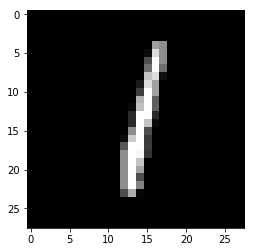

290 ---
1


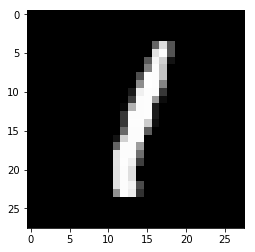

309 ---
1


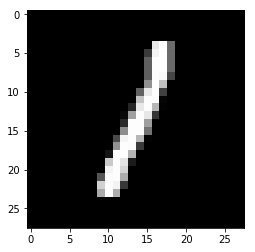

310 ---
1


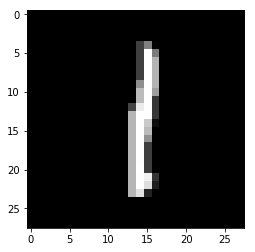

315 ---
1


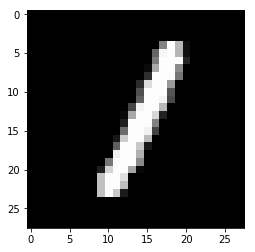

345 ---
1


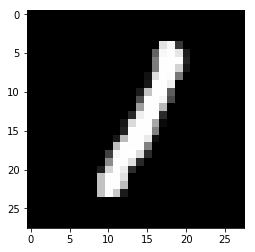

351 ---
1


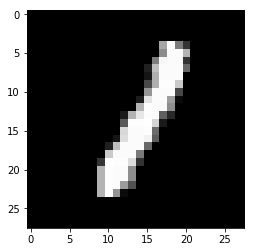

355 ---
1


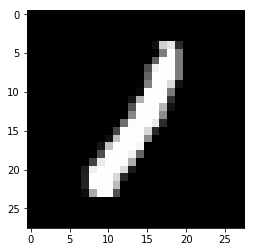

357 ---
1


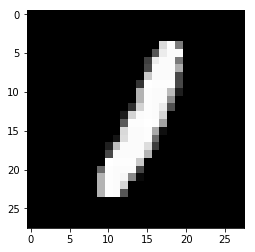

358 ---
1


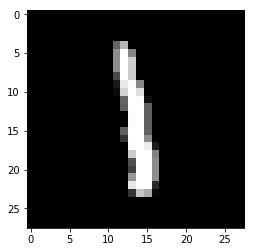

366 ---
1


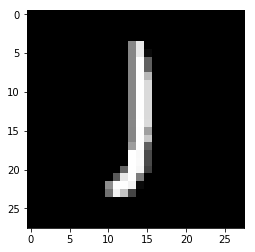

382 ---
1


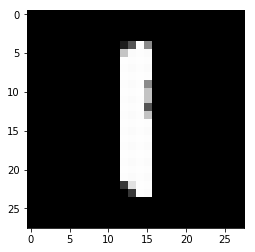

394 ---
1


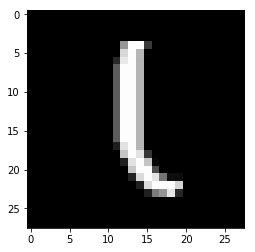

397 ---
1


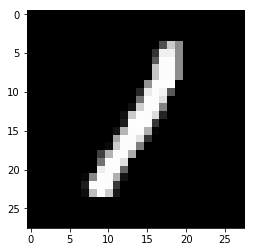

398 ---
1


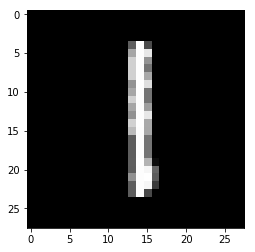

406 ---
1


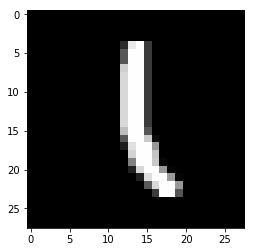

408 ---
1


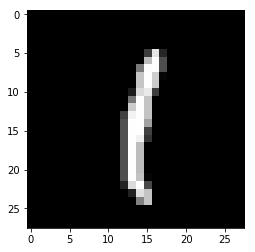

416 ---
1


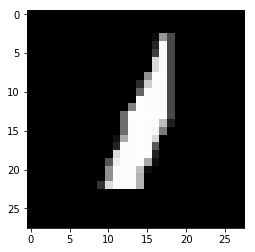

443 ---
1


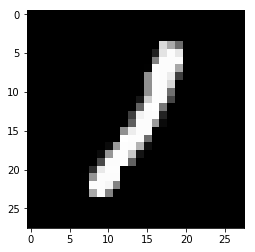

447 ---
1


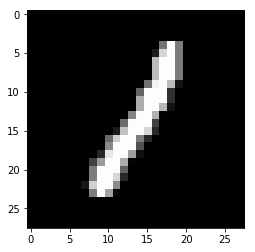

450 ---
1


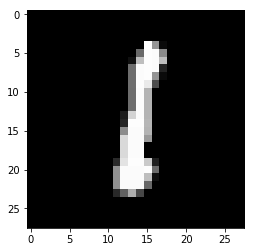

454 ---
1


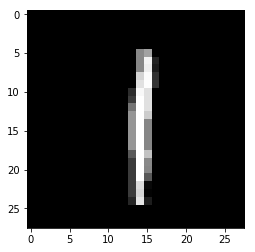

455 ---
1


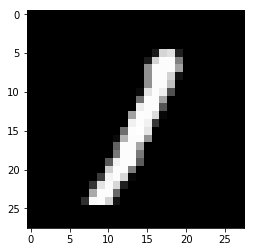

466 ---
1


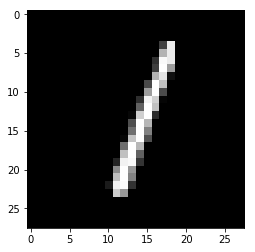

470 ---
1


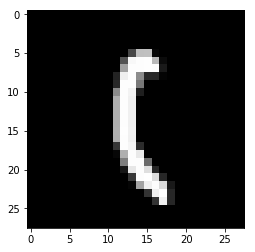

475 ---
1


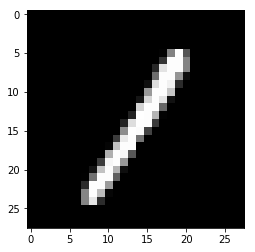

484 ---
1


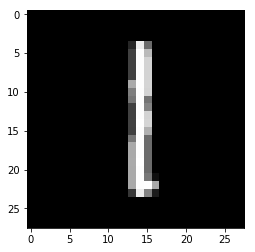

491 ---
1


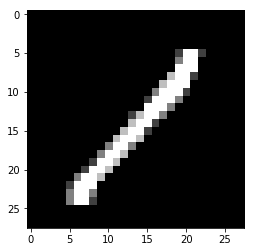

492 ---
1


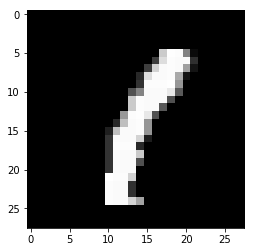

507 ---
1


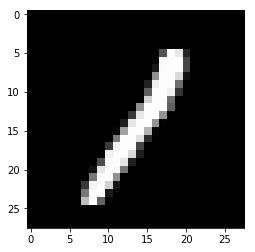

508 ---
1


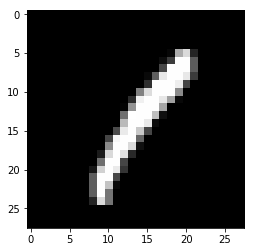

510 ---
1


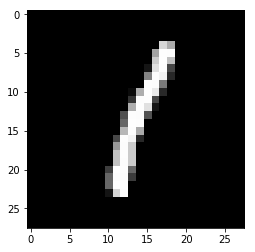

533 ---
1


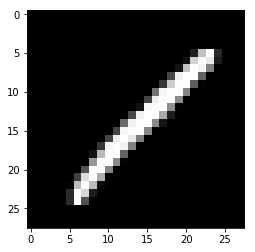

535 ---
1


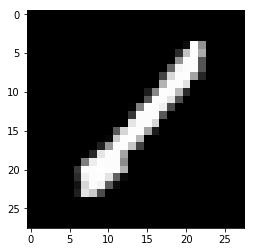

538 ---
1


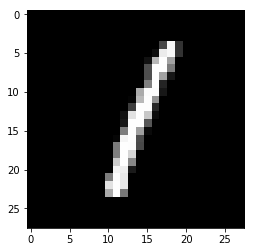

552 ---
1


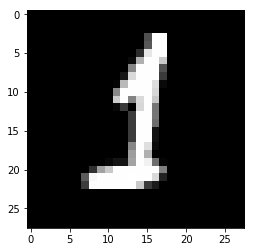

553 ---
1


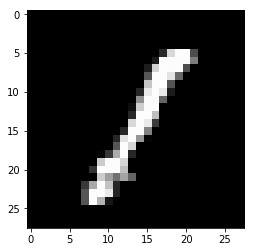

556 ---
1


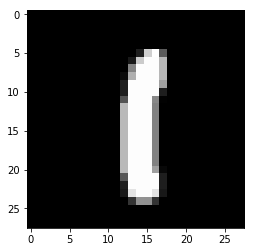

572 ---
1


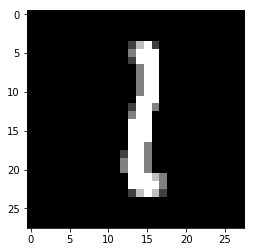

573 ---
1


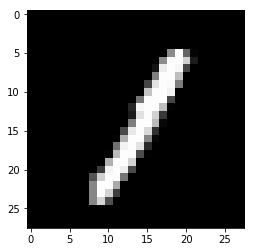

587 ---
1


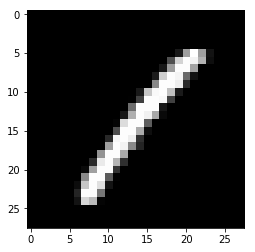

593 ---
1


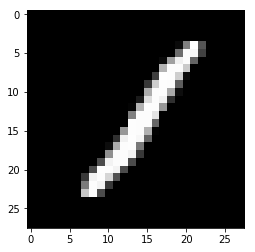

604 ---
1


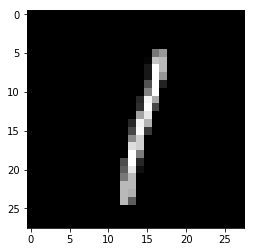

609 ---
1


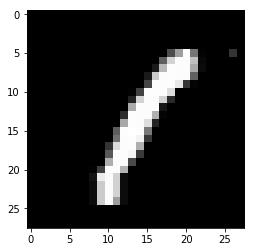

618 ---
1


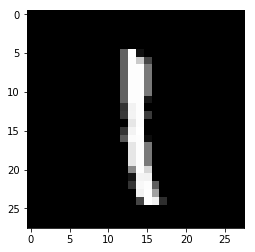

637 ---
1


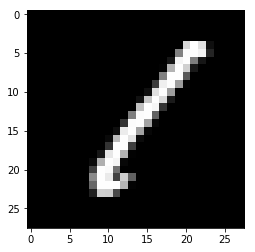

638 ---
1


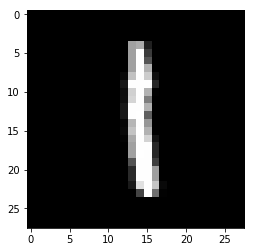

648 ---
1


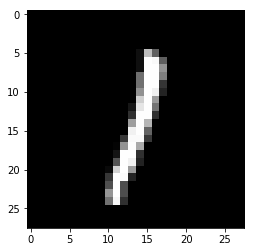

671 ---
1


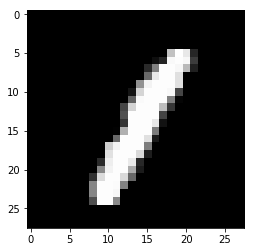

676 ---
1


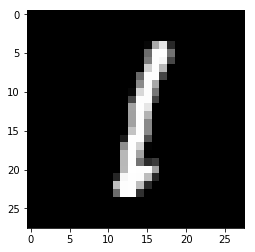

678 ---
1


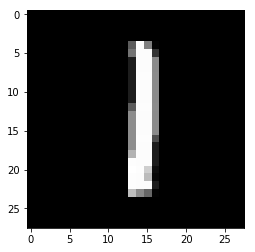

691 ---
1


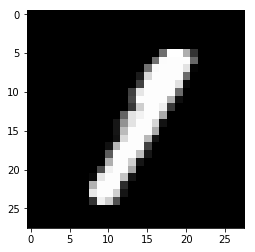

698 ---
1


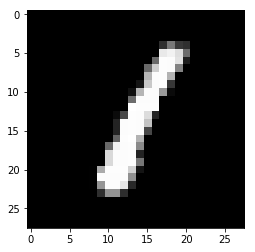

710 ---
1


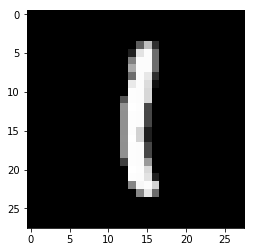

711 ---
1


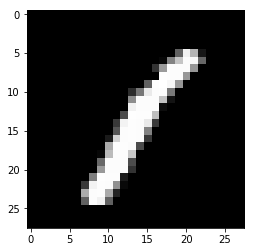

738 ---
1


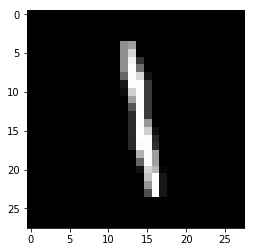

747 ---
1


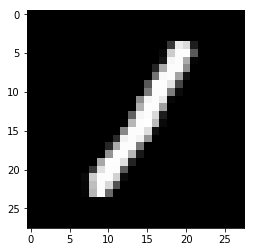

765 ---
1


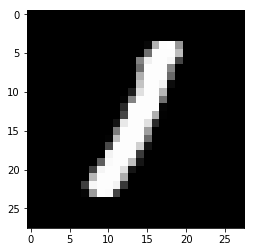

779 ---
1


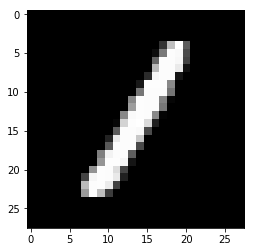

780 ---
1


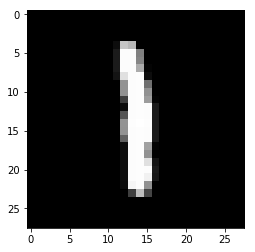

783 ---
1


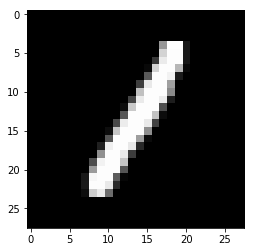

809 ---
1


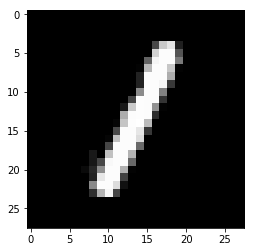

821 ---
1


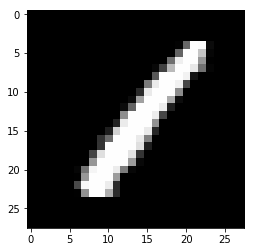

In [0]:
number_one_idx = np.where(labels_train == 1)
number_one_idx = np.resize(number_one_idx, [1, 100])
for x in np.nditer(number_one_idx):
  print(x, "---")
  print(labels_train[x])
  plt.imshow(digits_train[x])
  plt.show()

(1, 100)

# General

In [0]:
 print(pd.DataFrame(digits_train[0]))

    0   1   2   3    4    5    6    7   ...   20   21   22   23  24  25  26  27
0    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
1    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
2    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
3    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
4    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
5    0   0   0   0    0    0    0    0  ...  166  255  247  127   0   0   0   0
6    0   0   0   0    0    0    0    0  ...  253  242  195   64   0   0   0   0
7    0   0   0   0    0    0    0   49  ...   82   56   39    0   0   0   0   0
8    0   0   0   0    0    0    0   18  ...    0    0    0    0   0   0   0   0
9    0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
10   0   0   0   0    0    0    0    0  ...    0    0    0    0   0   0   0   0
11   0   0   0   0    0    0    0    0  

In [0]:
digits_train_flat[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

# **Antwort Teil 3**
Jedes Bild hat 28*28 Pixel die in einem array gespeichert sind. Wenn wir das array platten bekommen wir einen Vektor mit 784 Dimensionen der werten die die Itensität der Pixel beschreiben.

Der Grund warum KNN und KMEANS immer wieder scheitern ist, wenn sich Buchstaben ähnlich sind und damit im eindimensionalen Vektor ähnliche Strukturen aufweisen. Beispiele sieht man bei Antwort Teil 1 und Antwort Teil 2. Desweiteren lässt sich aus den oberen Ergebnissen (KNN, KMEANS, MNIST Datensatz visualisert) schließen, dass rauschen in den Bildern ebenfalls eine Rolle spielt. Auffällig war, dass Bilder mit rauschen und falschen Pixeln auch häufig falsch einstuft wurden. 

